<a href="https://colab.research.google.com/github/wkweigel/NotebookExamples/blob/main/3D_BuildingBlockAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, building block pools are analyzed to see how well thier combinatorial assemblies match the shape and electrostatic potential (ESP) of a specific reference compound (A co-crystal structure with a target protein).
Fluzoparib in its binding conformation with PARP2 (pdbID 8HKN) will be used as the reference compound.

General Workflow:
1. Generate a combinatorial virtual library using three building block pools.
2. Fingerprint each combination of building block fragments for model training.
3. Apply an active learning model that recursively applies a costly scoring function to small subsets of the whole library.
4. Asess training metrics and model quality.
5. Asess 3D overlap of the reference compound and the closest matching library compounds.
6. Generate bar plots showing the frequency of the top scoring building blocks.  


# Install condacolab

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:18
🔁 Restarting kernel...


# Notebook Setup
* This takes a few minutes to complete

In [2]:
import subprocess
import sys

subprocess.run("rm -rf /usr/local/conda-meta/pinned", shell=True)
subprocess.run("pip -q install py3Dmol", shell=True)
subprocess.run("!mamba install -c anaconda intel-openmp", shell=True)
subprocess.run("conda config --add channels http://conda.anaconda.org/psi4", shell=True)
subprocess.run("mamba install psi4 resp -c conda-forge/label/libint_dev -c conda-forge", shell=True)
subprocess.run("pip install joblib tqdm rdkit-pypi", shell=True)

#Clone main repository into colab
!git clone https://github.com/wkweigel/NotebookExamples.git

#Add directories to the path
main_dir = '/content/NotebookExamples'
sys.path.insert(0,f'{main_dir}/')

#Add directories to the path
module_dir = '/content/NotebookExamples/Modules'
sys.path.insert(0,f'{main_dir}/')

espsim_dir = '/content/NotebookExamples/Modules/espsim'
sys.path.insert(0,f'{espsim_dir}/')

#Test the espsim electrostatics import
from electrostatics import GetEspSim, GetShapeSim

#Import the required library modules
from Modules.ESPsim import*
from Modules.LibraryUtils import*
from Modules.ActiveLearning import*

import matplotlib.pyplot as plt



fatal: destination path 'NotebookExamples' already exists and is not an empty directory.


Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


# Load smiles that will be used to make a small virtual library
* A virual library will be generated from three building block pools:
  * A linker pool containing 8x bromo anilines.
  * A pool of 50x carboxylic acids (for amide bond formation with the linkers).
  * A pool of 50x amines (for Buchwald–Hartwig amination with the linkers).
* Here we will use a small library size (8x50x50=20,000) for demonstration purposes.

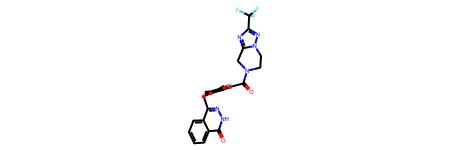

In [13]:

#Define some linkers.
linker_smiles = ['NCC4=CC=CC(Br)=C4',
                 'NCC5=CC=CC=C5Br',
                 'NC6=CC=CC(Br)=C6',
                 'NC1C2CC3=C(C(Br)=CC=C3)C12',
                 'BrC7=C(SC8=C7C=CC=C8)N',
                 'BrC9=CC=CC%10=C9SC(N)=C%10',
                 'BrC1=C(SC=C1)N',
                 'NC%11=CC(C=CC(Br)=C%12)=C%12S%11']


#Fetch some amines and carboxylic acids from csv files
Amine_df = pd.read_csv('/content/NotebookExamples/Datasets/Amine_Smiles.csv')
Acids_df = pd.read_csv('/content/NotebookExamples/Datasets/CA_Smiles.csv')

#Sample the amines and carboxylic acids
amine_smiles = Amine_df['Smiles'].sample(50).tolist()
acid_smiles = Acids_df['Smiles'].sample(50).tolist()

#Fetch the 3D refrence mol from file
fluzoparib_smiles = 'c1ccc2c(c1)C(=NNC2=O)Cc3ccc(c(c3)C(=O)N4CCn5c(nc(n5)C(F)(F)F)C4)F'
fluzoparib_sdf = Chem.SDMolSupplier("/content/NotebookExamples/Datasets/fluzoparib_H.sdf")
fluzoparib = fluzoparib_sdf[0]

# Preview the fluzoparib mol
fluzoparib

# Add Hs to the ref mol
* Here this is accomplished by doing a conformer search using a fluzoparib mol containing hydrogens and matching it to the structure without hydrogens.

In [4]:
fluzoparib_H, shape_sim, esp_sim, total_sim = get_esp_similarity_score(fluzoparib_smiles, fluzoparib)
draw_overlay(fluzoparib, fluzoparib_H)

[08:06:11] Molecule does not have explicit Hs. Consider calling AddHs()
/content/NotebookExamples/Modules/espsim/helpers.py:18: UserWarning: Input molecule missing hydrogens. Use Chem.AddHs() to make hydrogens explicit.
  warnings.warn('Input molecule missing hydrogens. Use Chem.AddHs() to make hydrogens explicit.')


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Create the Combinatorial Library
* Note that the fully assembled library compounds have not been created yet. Instead, a 'union_SMILES' column has been created simply by joing the building block fragments into a single SMILES string.
* Structural information about the fragments can be sufficently captured with morgan fingerprints without needing to generate product smiles.
* Avoiding the need for creating the combinatorial products can be helpful for larger libraries.
* The final library compounds will be assembled in small batches as they are needed to pass to the shape/esp scoring function.

In [14]:
#Make the library dataframe
library_df = library_df_from_bb_pools(linker_smiles, acid_smiles, amine_smiles)

#Add columns used by the acitve learning model
library_df["sf_scores"] = np.NaN
library_df["model_scores"] = np.NaN
library_df["scored_round"] = np.NaN
library_df.head()

library_df.head()


,bbA_ID,bbB_ID,bbC_ID,bbA_SMILES,bbB_SMILES,bbC_SMILES,union_SMILES,sf_scores,model_scores,scored_round
A001_B001_C001,A001,B001,C001,NCC4=CC=CC(Br)=C4,ClC1(=C(Cl)C=CC(=C1)CC(=O)O),NCc1c[s]cc1,NCC4=CC=CC(Br)=C4.ClC1(=C(Cl)C=CC(=C1)CC(=O)O)...,NaN,NaN,NaN
A001_B001_C002,A001,B001,C002,NCC4=CC=CC(Br)=C4,ClC1(=C(Cl)C=CC(=C1)CC(=O)O),CC(N=C(N1)N(CC2)CCC2N)=CC1=O,NCC4=CC=CC(Br)=C4.ClC1(=C(Cl)C=CC(=C1)CC(=O)O)...,NaN,NaN,NaN
A001_B001_C003,A001,B001,C003,NCC4=CC=CC(Br)=C4,ClC1(=C(Cl)C=CC(=C1)CC(=O)O),CC(CO)(CO)N,NCC4=CC=CC(Br)=C4.ClC1(=C(Cl)C=CC(=C1)CC(=O)O)...,NaN,NaN,NaN
A001_B001_C004,A001,B001,C004,NCC4=CC=CC(Br)=C4,ClC1(=C(Cl)C=CC(=C1)CC(=O)O),NCCN1CCCCC1,NCC4=CC=CC(Br)=C4.ClC1(=C(Cl)C=CC(=C1)CC(=O)O)...,NaN,NaN,NaN
A001_B001_C005,A001,B001,C005,NCC4=CC=CC(Br)=C4,ClC1(=C(Cl)C=CC(=C1)CC(=O)O),COc1cc(F)c(CN)cc1,NCC4=CC=CC(Br)=C4.ClC1(=C(Cl)C=CC(=C1)CC(=O)O)...,NaN,NaN,NaN


Example of a 'union_SMILES'

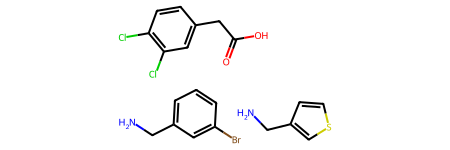

In [15]:
Chem.MolFromSmiles(list(library_df['union_SMILES'])[0])

# Fingerprint the BB Smiles

In [16]:
#Make the fingerprint dataframe
fp_df = create_morgan_fingerprints(library_df, smiles_col='union_SMILES')

Generating Mols...


Failed to patch pandas - unable to change molecule rendering
100%|██████████| 20000/20000 [00:20<00:00, 992.28it/s] 


#Perform the Active Learning
This method is adapted from the following repo by Jon Swain: https://github.com/jonswain/active-learning

Process:
1. Asemble the BBs for n compounds (5-20) and score them using the scoring function (costly step).
2. Train an RF model on the union_SMILES fingerprints for the scored compounds.
3. Apply the model to the unscored compounds to get predicted scores (inexpensive step).
4. Get the compounds with the top n predicted scores and repeat.

This allows the estimation of scores for the whole library by using the costly scoring function on only 50-100 compounds.



In [17]:
# Active learning parameters
COMPOUNDS_PER_ROUND = 5
NUMBER_OF_ROUNDS = 10
MINIMIZE = False
NUMBER_OF_REPEATS = 1


# Run active learning
print("Running active learning")
scored_compounds_per_run = []
for i in tqdm(range(NUMBER_OF_REPEATS)):
    # Reset library between rounds
    library_df["sf_scores"] = np.NaN
    library_df["model_scores"] = np.NaN
    library_df["scored_round"] = np.NaN

    # Active learning
    library_df, metrics = run_active_learning_with_metrics(
        library_df=library_df,
        fingerprint_df=fp_df,
        BB_Cols=['bbA_SMILES', 'bbB_SMILES', 'bbC_SMILES'],
        compounds_per_round=COMPOUNDS_PER_ROUND,
        number_of_rounds=NUMBER_OF_ROUNDS,
        scoring_function=espsim_scoring_function,
        minimize=MINIMIZE,
        ref_mol=fluzoparib_H)

Running active learning


100%|██████████| 5/5 [01:17<00:00, 15.45s/it]


Round 0 (5 compounds): Spearman Correlation = 1.0000, MAE = 0.0326



100%|██████████| 5/5 [01:11<00:00, 14.25s/it]


Round 1 (10 compounds): Spearman Correlation = 0.9879, MAE = 0.0400



100%|██████████| 5/5 [01:00<00:00, 12.15s/it]


Round 2 (15 compounds): Spearman Correlation = 0.9857, MAE = 0.0411



100%|██████████| 5/5 [01:01<00:00, 12.38s/it]


Round 3 (20 compounds): Spearman Correlation = 0.9910, MAE = 0.0352



100%|██████████| 5/5 [01:07<00:00, 13.53s/it]


Round 4 (25 compounds): Spearman Correlation = 0.9808, MAE = 0.0401



100%|██████████| 5/5 [01:18<00:00, 15.79s/it]


Round 5 (30 compounds): Spearman Correlation = 0.9880, MAE = 0.0476



100%|██████████| 5/5 [01:02<00:00, 12.55s/it]


Round 6 (35 compounds): Spearman Correlation = 0.9773, MAE = 0.0405



100%|██████████| 5/5 [00:51<00:00, 10.30s/it]


Round 7 (40 compounds): Spearman Correlation = 0.9568, MAE = 0.0492



100%|██████████| 5/5 [01:02<00:00, 12.41s/it]


Round 8 (45 compounds): Spearman Correlation = 0.9738, MAE = 0.0493



100%|██████████| 5/5 [01:00<00:00, 12.00s/it]


Round 9 (50 compounds): Spearman Correlation = 0.9769, MAE = 0.0505



100%|██████████| 1/1 [12:01<00:00, 721.68s/it]


# Training and Model Analysis

Plot the metrics (Spearman correlation and MAE) over each training round

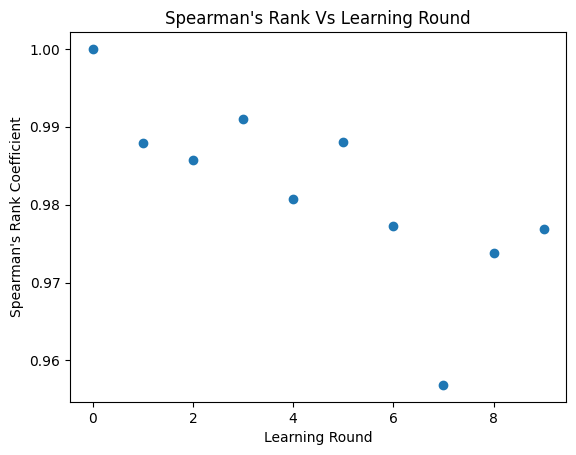

In [18]:


# Create the scatter plot
plt.scatter(metrics["round"], metrics["spearman"])

# Add labels and title
plt.xlabel("Learning Round")
plt.ylabel("Spearman's Rank Coefficient")
plt.title("Spearman's Rank Vs Learning Round")

# Show the plot
plt.show()

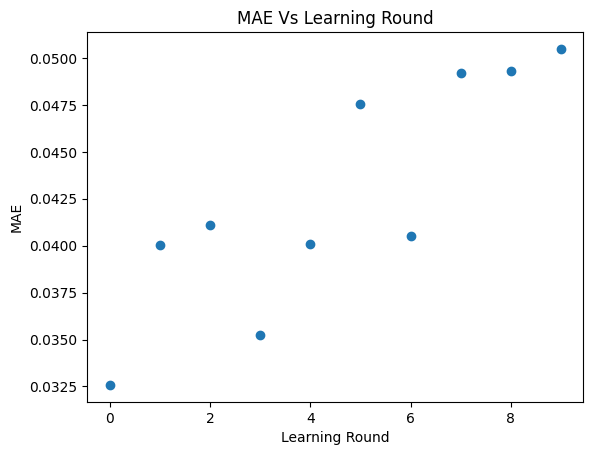

In [19]:
# Create the scatter plot
plt.scatter(metrics["round"], metrics["mae"])

# Add labels and title
plt.xlabel("Learning Round")
plt.ylabel("MAE")
plt.title("MAE Vs Learning Round")

# Show the plot
plt.show()

Plot scoring function results vs model predictions

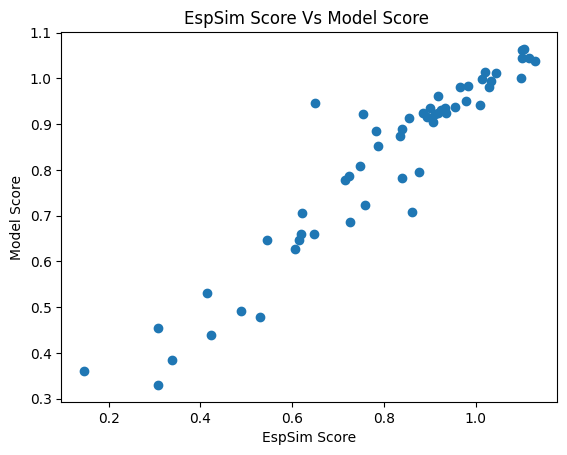

In [20]:
scored_library = library_df[library_df["sf_scores"].notna()]

plt.scatter(scored_library["sf_scores"], scored_library["model_scores"])

# Add labels and title
plt.xlabel("EspSim Score")
plt.ylabel("Model Score")
plt.title("EspSim Score Vs Model Score ")

# Show the plot
plt.show()

# 3D Overlay Analysis

Visualize the top scoring compounds overlaid with the reference compound

In [21]:
def generate_espsim_df2(df:pd.DataFrame, smiles_col:str, ref_mol):
    """
    Calculates and collects espsim score data (shape and ESP similarity) for smiles in dataframe with a reference mol.

    Parameters:
        df (DataFrame): DataFrame containing the smiles for scoring.
        smiles_col (str): The name of the dataframe containing the smiles to use for .
        ref_mol (Mol): Reference molecule (RDKit Mol object).

    Returns:
        espsim df (DataFrame): A dataframe containing conformer mols, shape similarity scores, esp similarity scores, and total similarity scores.
    """
    sim_data = []
    for smi in tqdm(df[smiles_col]):
        best_conf, shape_sim, esp_sim, total_sim = get_esp_similarity_score(smi, ref_mol)
        if best_conf == None:
            continue
        sim_series = pd.Series({'conformer_mol':best_conf, 'shape_sim':shape_sim,  'esp_sim': esp_sim, 'total_sim':total_sim})
        sim_data.append(sim_series)
    espsim_df = pd.concat(sim_data, axis=1).T.reset_index(drop=True)
    return espsim_df


sorted_library=library_df.sort_values(by='sf_scores', ascending=False)

pruned_df = sorted_library.head(12)
# Convert the index to a column
pruned_df = pruned_df.reset_index()


linkers = list(pruned_df['bbA_SMILES'])
acids = list(pruned_df['bbB_SMILES'])
amines = list(pruned_df['bbC_SMILES'])
prods = [assemble_three_cycle_BBs(linkers[i], acids[i], amines[i]) for i in range(len(linkers))]
pruned_df['Assembled_Smiles'] = prods

espsim_df = generate_espsim_df2(pruned_df, 'Assembled_Smiles', fluzoparib_H)
espsim_df.sort_values(by='total_sim', ascending=False, inplace=True, ignore_index=True)
draw_overlays(fluzoparib_H, espsim_df, grid_size=(4,3))

100%|██████████| 12/12 [02:18<00:00, 11.57s/it]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Top Building Block Analysis

Make histograms for each BB pool showing the BB distribution across the top scoring compounds.

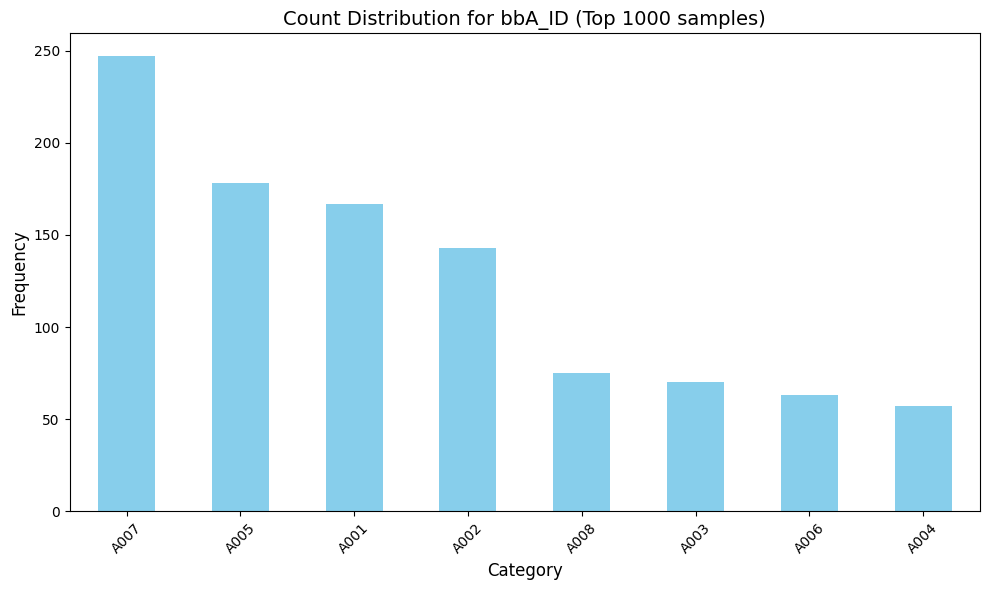

In [22]:

plot_bb_histogram(library_df, 'bbA_ID', 'model_scores', 1000)


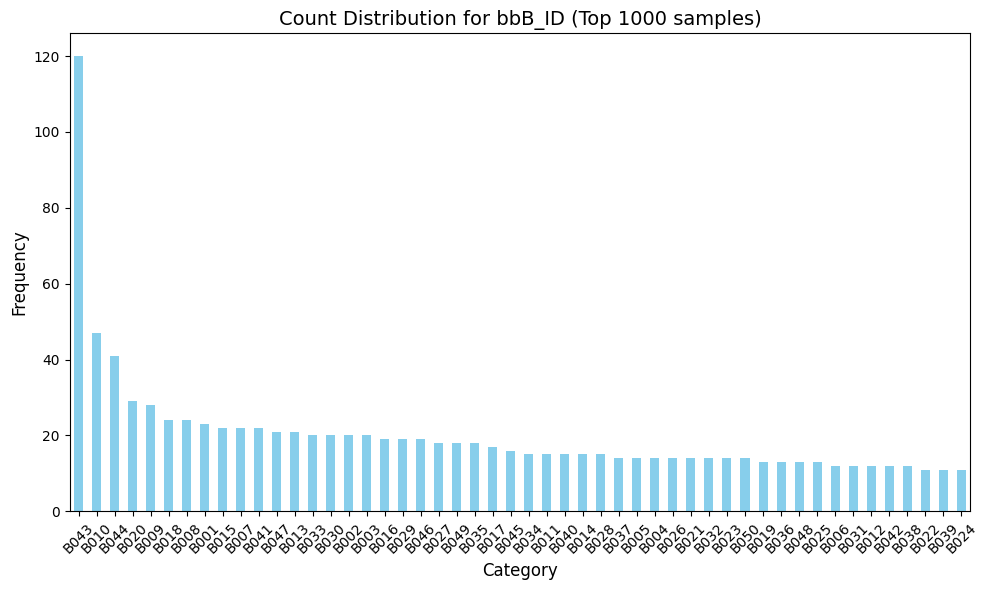

In [23]:
plot_bb_histogram(library_df, 'bbB_ID', 'model_scores', 1000)

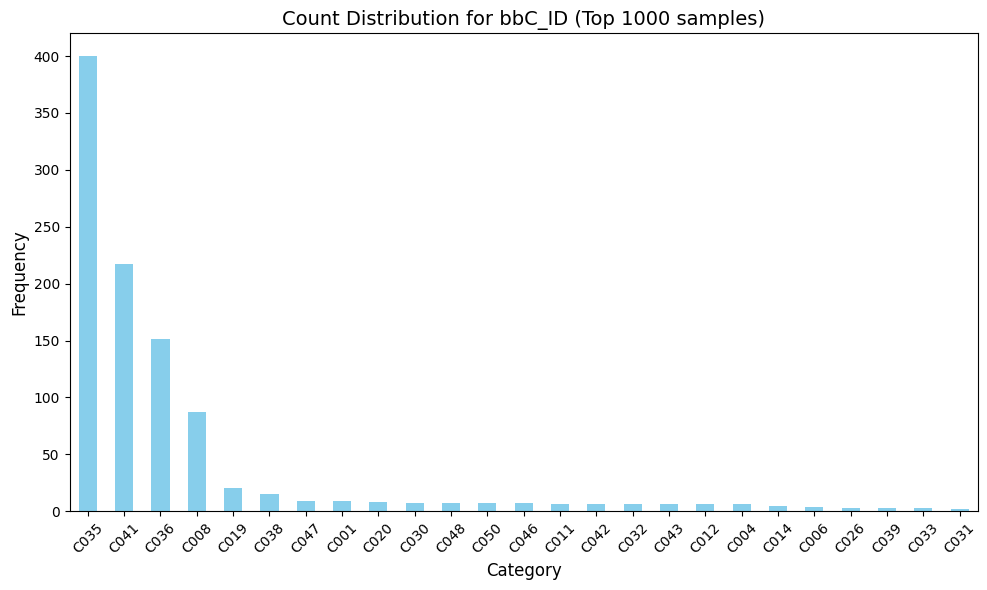

In [24]:
plot_bb_histogram(library_df, 'bbC_ID', 'model_scores', 1000)